Imports

In [85]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from src.data_loading.TOPASXRD_data_loader import create_data_loaders
import scripts.training.config_training as config_training

%matplotlib inline
plt.style.use('seaborn-v0_8')

Set Directories

In [76]:
# Set the working directory to the base of the repo if it isn't already
os.chdir('/monfs01/projects/ys68/XRD_phase_analysis')

# Replace with your actual data directory
data_dir = "training_data/processed_data_test_1"  

Load Data

In [77]:
# Load intensities
intensities = np.load(os.path.join(data_dir, 'intensities.npy'))

# Load weight fractions
weight_fractions = pd.read_csv(os.path.join(data_dir, 'weight_fractions.csv'))

# Load additional parameters
additional_params = pd.read_csv(os.path.join(data_dir, 'additional_params.csv'))

# Load metadata
with open(os.path.join(data_dir, 'metadata.json'), 'r') as f:
    metadata = json.load(f)

print(f"Loaded {len(intensities)} XRD patterns")
print(f"Shape of intensities array: {intensities.shape}")

Loaded 50 XRD patterns
Shape of intensities array: (50, 7250)


Plot Example Data

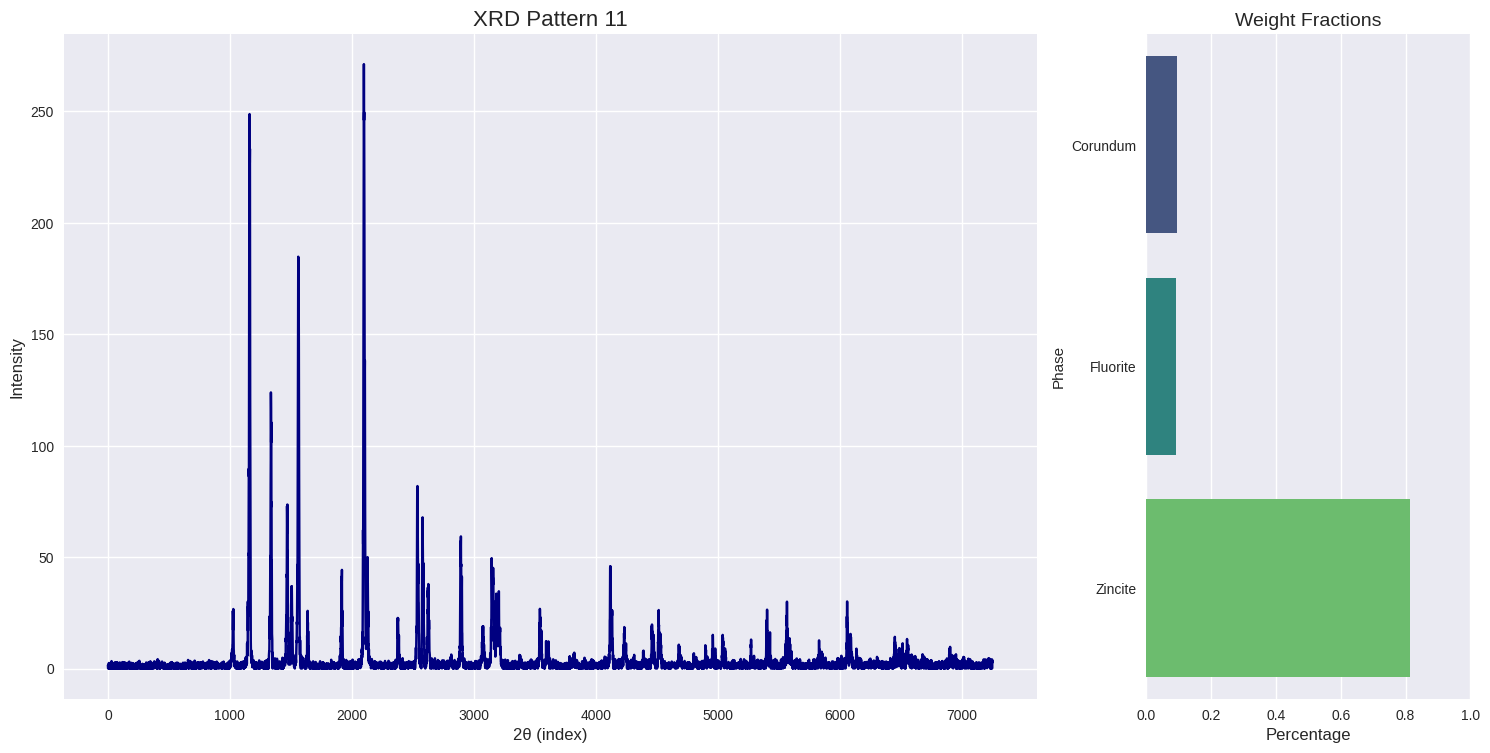

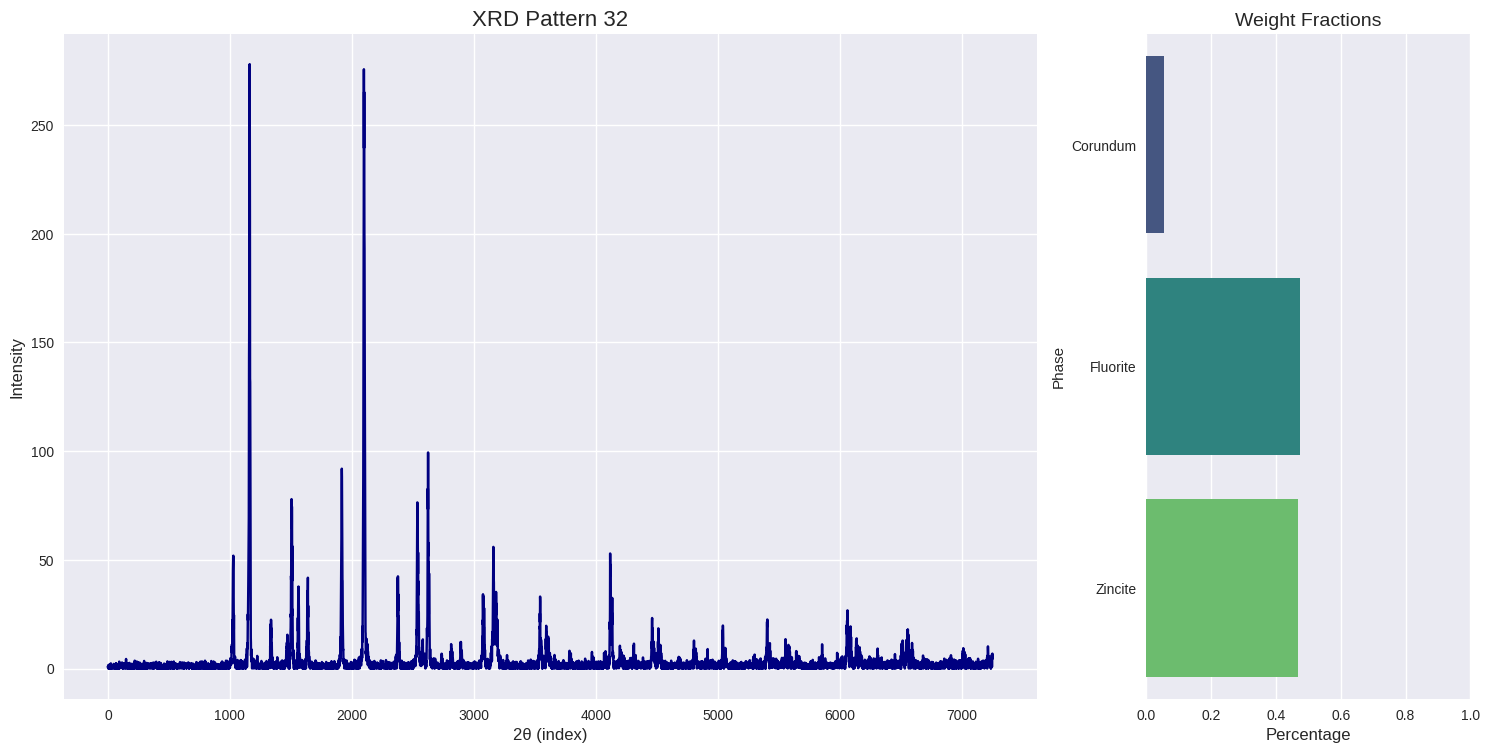

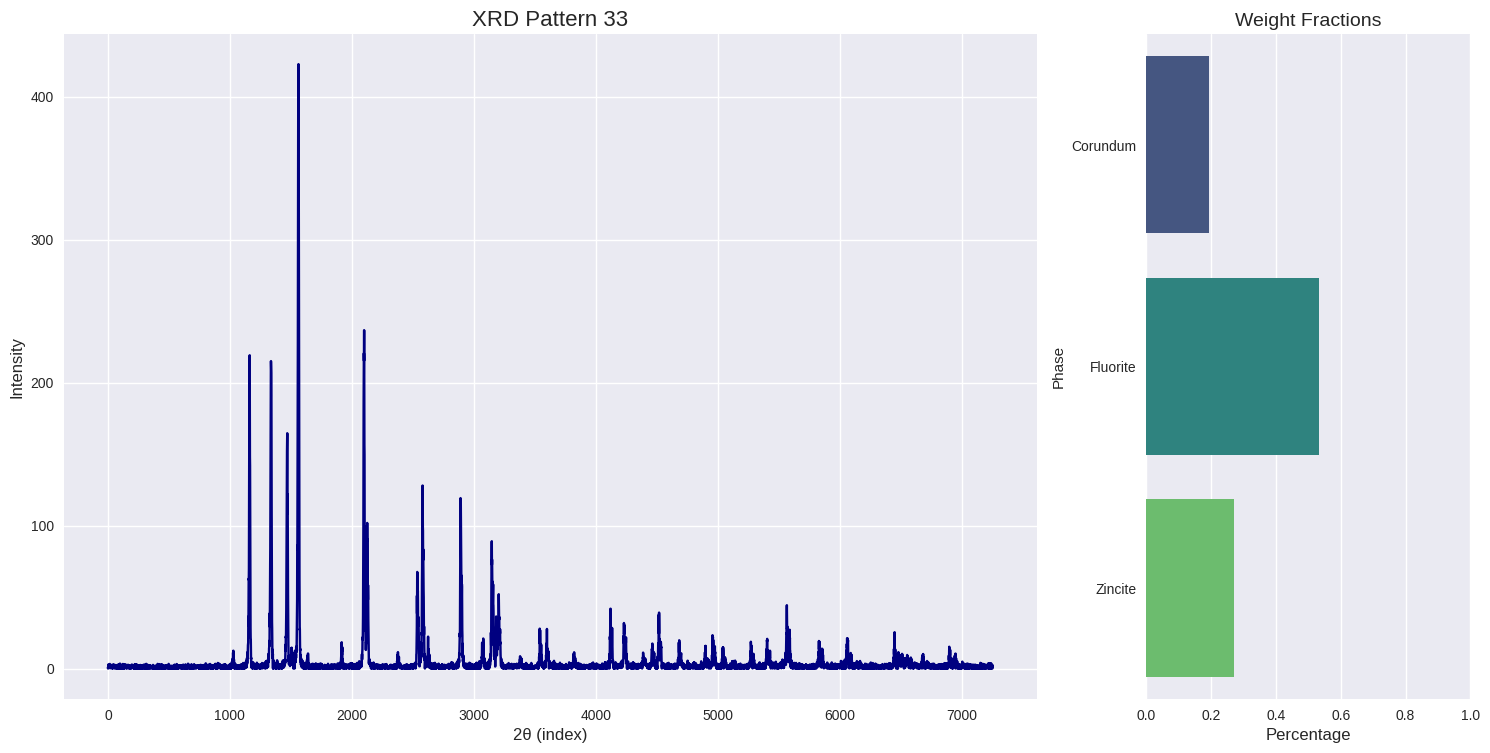

In [84]:
# TODO: 2 theta to degrees instead of index
# TODO: Add additional params?

# Create a fixed color map for all phases
all_phases = weight_fractions.columns.tolist()
color_palette = dict(zip(all_phases, sns.color_palette("viridis", len(all_phases))))

def plot_xrd_pattern(intensity, index, weight_fractions, additional_params, title=None):
    # Set up the matplotlib figure
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])
    
    # Plot XRD pattern
    ax_main = fig.add_subplot(gs[0, 0])
    ax_main.plot(range(len(intensity)), intensity, color='navy')
    ax_main.set_xlabel('2θ (index)', fontsize=12)
    ax_main.set_ylabel('Intensity', fontsize=12)
    if title:
        ax_main.set_title(title, fontsize=16)
    
    # Plot weight fractions as a horizontal bar chart
    ax_weight = fig.add_subplot(gs[0, 1])
    
    # Create a DataFrame with all phases, filling missing values with 0
    weight_df = pd.DataFrame({'Phase': all_phases, 
                              'Percentage': [weight_fractions.loc[index, phase] if phase in weight_fractions.columns else 0 
                                             for phase in all_phases]})
    
    # Sort by the global order of phases
    weight_df['Phase'] = pd.Categorical(weight_df['Phase'], categories=all_phases, ordered=True)
    weight_df = weight_df.sort_values('Phase')
    
    # Plot the bar chart
    sns.barplot(data=weight_df, x='Percentage', y='Phase', ax=ax_weight, hue='Phase', palette=color_palette, dodge=False, legend=False)     
    ax_weight.set_title('Weight Fractions', fontsize=14)
    ax_weight.set_xlabel('Percentage', fontsize=12)
    ax_weight.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Plot 3 random XRD patterns with phase information
for i in range(3):
    random_index = np.random.randint(0, len(intensities))
    plot_xrd_pattern(intensities[random_index], random_index, weight_fractions, additional_params, 
                     f"XRD Pattern {random_index}")

Look at distributions

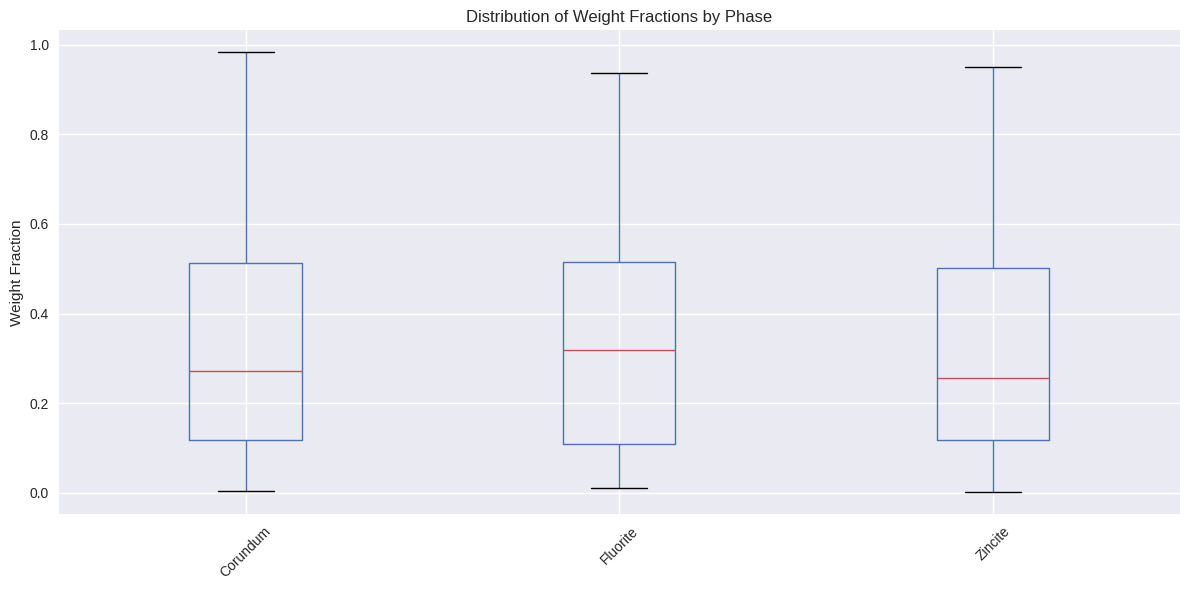

Average weight fractions:
Corundum    0.327124
Fluorite    0.345636
Zincite     0.327241
dtype: float64


In [79]:
plt.figure(figsize=(12, 6))
weight_fractions.boxplot()
plt.title('Distribution of Weight Fractions by Phase')
plt.ylabel('Weight Fraction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print average weight fractions
avg_weight_fractions = weight_fractions.mean()
print("Average weight fractions:")
print(avg_weight_fractions)

In [82]:
# TODO: Visualise the distribution of the other parameters.

Analyse a trained model


In [89]:
# Choose which model to load. Make sure the training config is the right model (Sorry)
model = config_training.MODEL_CLASS[config_training.MODEL_TYPE]()
model.load_state_dict(torch.load('trained_models/smallFCN_mae_0.2594_20241008_214038.pth'))
model.eval()

NameError: name 'smallFCN' is not defined

In [ ]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create data loaders
_, _, test_loader = create_data_loaders(
    config_training.DATA_DIR,
    config_training.BATCH_SIZE,
    config_training.NUM_WORKERS
)

# Perform inference on the test set
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target, _ in test_loader:
        data = data.unsqueeze(1).to(device)  # Add channel dimension
        output = model(data)
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.numpy())

predictions = np.concatenate(all_predictions)
targets = np.concatenate(all_targets)

/tmp/ipykernel_3060281/408196545.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


ValueError: x and y must be the same size

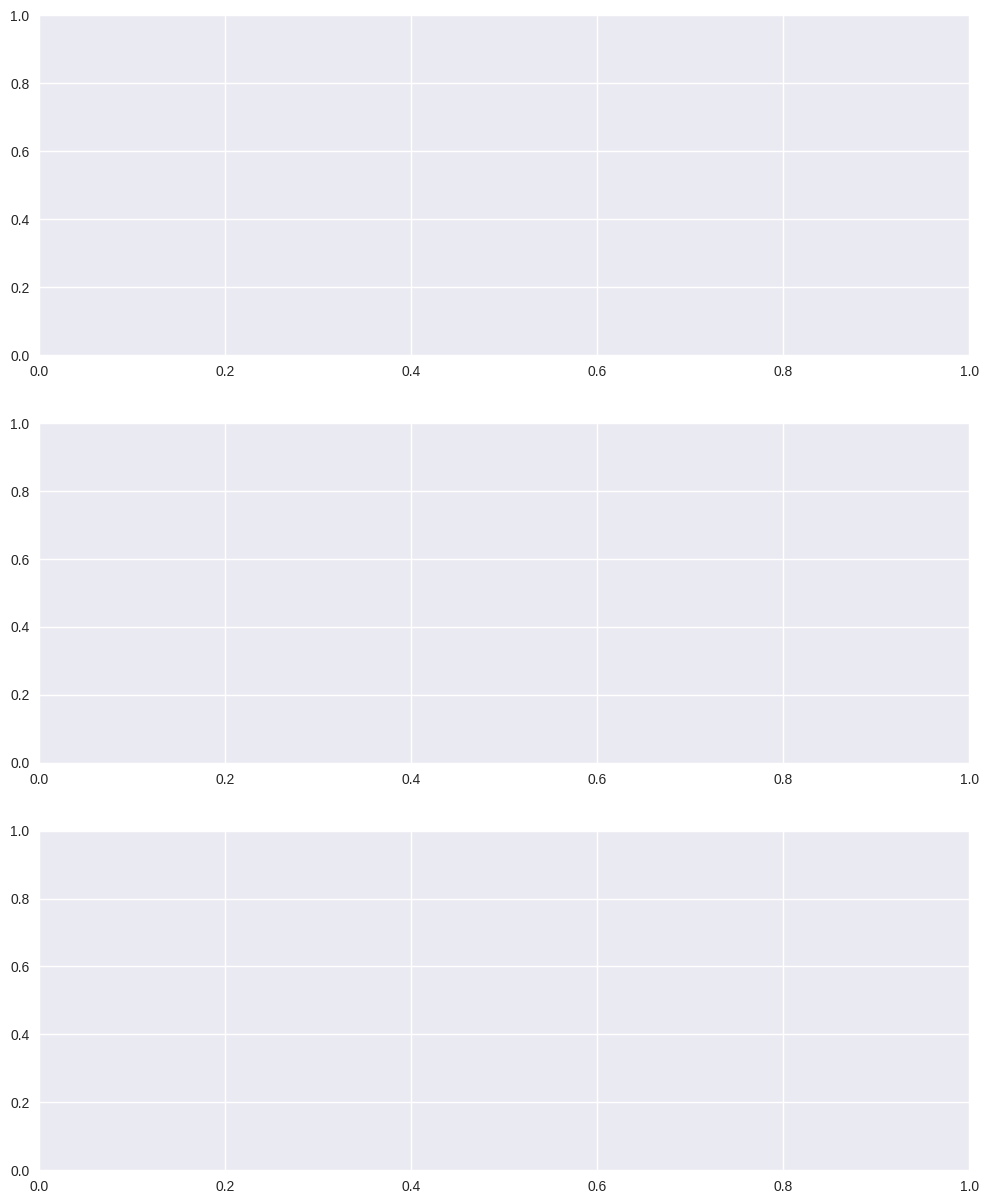

In [ ]:
def plot_predictions_vs_actual(predictions, targets, phase_names):
    n_phases = predictions.shape[1]
    fig, axes = plt.subplots(n_phases, 1, figsize=(12, 5*n_phases))
    
    for i, (ax, phase) in enumerate(zip(axes, phase_names)):
        ax.scatter(targets[:, i], predictions[:, i], alpha=0.5)
        ax.plot([0, 1], [0, 1], 'r--')  # Diagonal line
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title(f'{phase} Weight Fraction')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Get phase names from the weight_fractions DataFrame
phase_names = weight_fractions.columns.tolist()

# Plot predictions vs actual values
plot_predictions_vs_actual(predictions, targets, phase_names)

      Phase       MAE       MSE        R2
0  Corundum  0.245602  0.092590 -0.747950
1  Fluorite  0.269270  0.126339 -0.412850
2   Zincite  0.134231  0.034109 -0.136199


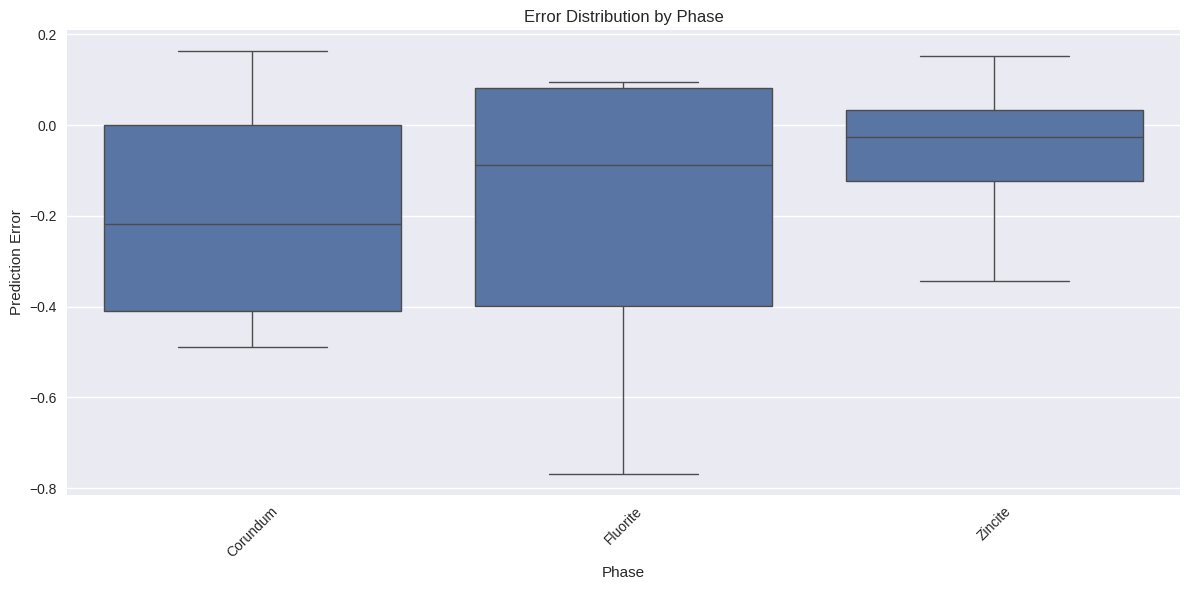

In [ ]:
def calculate_metrics(predictions, targets):
    mae = np.mean(np.abs(predictions - targets), axis=0)
    mse = np.mean((predictions - targets)**2, axis=0)
    r2 = 1 - np.sum((targets - predictions)**2, axis=0) / np.sum((targets - np.mean(targets, axis=0))**2, axis=0)
    
    return mae, mse, r2

mae, mse, r2 = calculate_metrics(predictions, targets)

# Display metrics
metrics_df = pd.DataFrame({
    'Phase': phase_names,
    'MAE': mae,
    'MSE': mse,
    'R2': r2
})

print(metrics_df)

# Visualize error distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.melt(pd.DataFrame(predictions - targets, columns=phase_names)), x='variable', y='value')
plt.title('Error Distribution by Phase')
plt.xlabel('Phase')
plt.ylabel('Prediction Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Worst Prediction 1:
Actual vs Predicted:
Corundum: 0.0334 vs 0.1957
Fluorite: 0.9015 vs 0.1335
Zincite: 0.0651 vs 0.2033



TypeError: object of type 'numpy.float32' has no len()

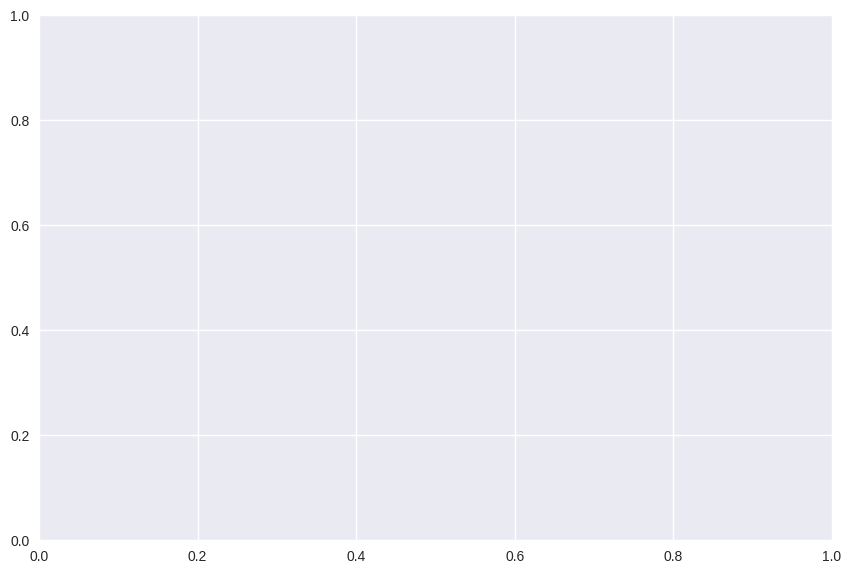

In [ ]:
def plot_worst_predictions(predictions, targets, test_loader, phase_names, n=3):
    errors = np.mean(np.abs(predictions - targets), axis=1)
    worst_indices = np.argsort(errors)[-n:][::-1]
    
    # Get all test data
    all_intensities = []
    all_additional_params = []
    for data, _, add_params in test_loader:
        all_intensities.append(data.numpy())
        all_additional_params.append(add_params.numpy())
    all_intensities = np.concatenate(all_intensities)
    all_additional_params = np.concatenate(all_additional_params)
    
    for i, idx in enumerate(worst_indices):
        print(f"Worst Prediction {i+1}:")
        print("Actual vs Predicted:")
        for phase, actual, pred in zip(phase_names, targets[idx], predictions[idx]):
            print(f"{phase}: {actual:.4f} vs {pred:.4f}")
        print()
        
        # Use the relative index to get the corresponding intensity and additional params
        intensity = all_intensities[idx, 0]  # Assuming the intensity is in the first channel
        add_params = all_additional_params[idx]
        
        plot_xrd_pattern(intensity, idx, 
                         pd.DataFrame([targets[idx]], columns=phase_names),
                         pd.DataFrame([add_params], columns=additional_params.columns),
                         f"Worst Prediction {i+1}")

# Plot worst predictions
plot_worst_predictions(predictions, targets, test_loader, phase_names)

In [ ]:
import scripts.training.config_training as config_training

# Load the model
model = config_training.MODEL_CLASS[config_training.MODEL_TYPE]()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to load and process XY files
def load_xy_file(file_path):
    data = np.loadtxt(file_path, skiprows=1)
    intensities = data[:, 1]  # Second column contains intensities
    return intensities

# Load and process XY files
sample_dir = 'analysis/Madsen_Round_Robin_2004/samples'
xy_files = [f for f in os.listdir(sample_dir) if f.endswith('.xy')]
xy_files.sort()  # Sort alphabetically to match weight_fractions.csv

intensities = []
for file in xy_files:
    intensity = load_xy_file(os.path.join(sample_dir, file))
    intensities.append(intensity)

# Convert to numpy array and reshape for the model
intensities = np.array(intensities)
intensities = intensities.reshape(intensities.shape[0], 1, -1)  # Add channel dimension

# Convert to torch tensor
intensities_tensor = torch.FloatTensor(intensities).to(device)

# Perform inference
model.eval()
with torch.no_grad():
    predictions = model(intensities_tensor)

# Convert predictions to numpy array
predictions = predictions.cpu().numpy()

# Load weight fractions
weight_fractions = pd.read_csv('analysis/Madsen_Round_Robin_2004/weight_fractions.csv')

# Print results
for i, (file, pred) in enumerate(zip(xy_files, predictions)):
    print(f"Sample: {file}")
    print("Predicted vs Actual:")
    for j, phase in enumerate(weight_fractions.columns):
        predicted = pred[j]
        actual = weight_fractions.iloc[i, j]
        print(f"{phase}: {predicted:.4f} vs {actual:.4f}")
    print()

# Calculate and print metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(weight_fractions, predictions)
mse = mean_squared_error(weight_fractions, predictions)
r2 = r2_score(weight_fractions, predictions)

print("Overall Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

Sample: CORUNDUM.xy
Predicted vs Actual:
Corundum: 1.4436 vs 1.0000
Fluorite: 1.8115 vs 0.0000
Zincite: 2.0615 vs 0.0000

Sample: CPD-1A.xy
Predicted vs Actual:
Corundum: 1.2412 vs 0.0115
Fluorite: 1.5525 vs 0.9481
Zincite: 1.7736 vs 0.0404

Sample: CPD-1B.xy
Predicted vs Actual:
Corundum: 1.3019 vs 0.9431
Fluorite: 1.6208 vs 0.0433
Zincite: 1.8502 vs 0.0136

Sample: CPD-1C.xy
Predicted vs Actual:
Corundum: 2.4522 vs 0.0504
Fluorite: 3.1800 vs 0.0136
Zincite: 3.5737 vs 0.9359

Sample: CPD-1D.xy
Predicted vs Actual:
Corundum: 1.2286 vs 0.1353
Fluorite: 1.5342 vs 0.5358
Zincite: 1.7531 vs 0.3289

Sample: CPD-1E.xy
Predicted vs Actual:
Corundum: 1.0500 vs 0.5512
Fluorite: 1.2888 vs 0.2962
Zincite: 1.4820 vs 0.1525

Sample: CPD-1F.xy
Predicted vs Actual:
Corundum: 1.5599 vs 0.2706
Fluorite: 1.9770 vs 0.1772
Zincite: 2.2431 vs 0.5522

Sample: CPD-1G.xy
Predicted vs Actual:
Corundum: 1.2012 vs 0.3137
Fluorite: 1.4951 vs 0.3442
Zincite: 1.7100 vs 0.3421

Sample: CPD-1H.xy
Predicted vs Actual:

/tmp/ipykernel_3060281/2162900053.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


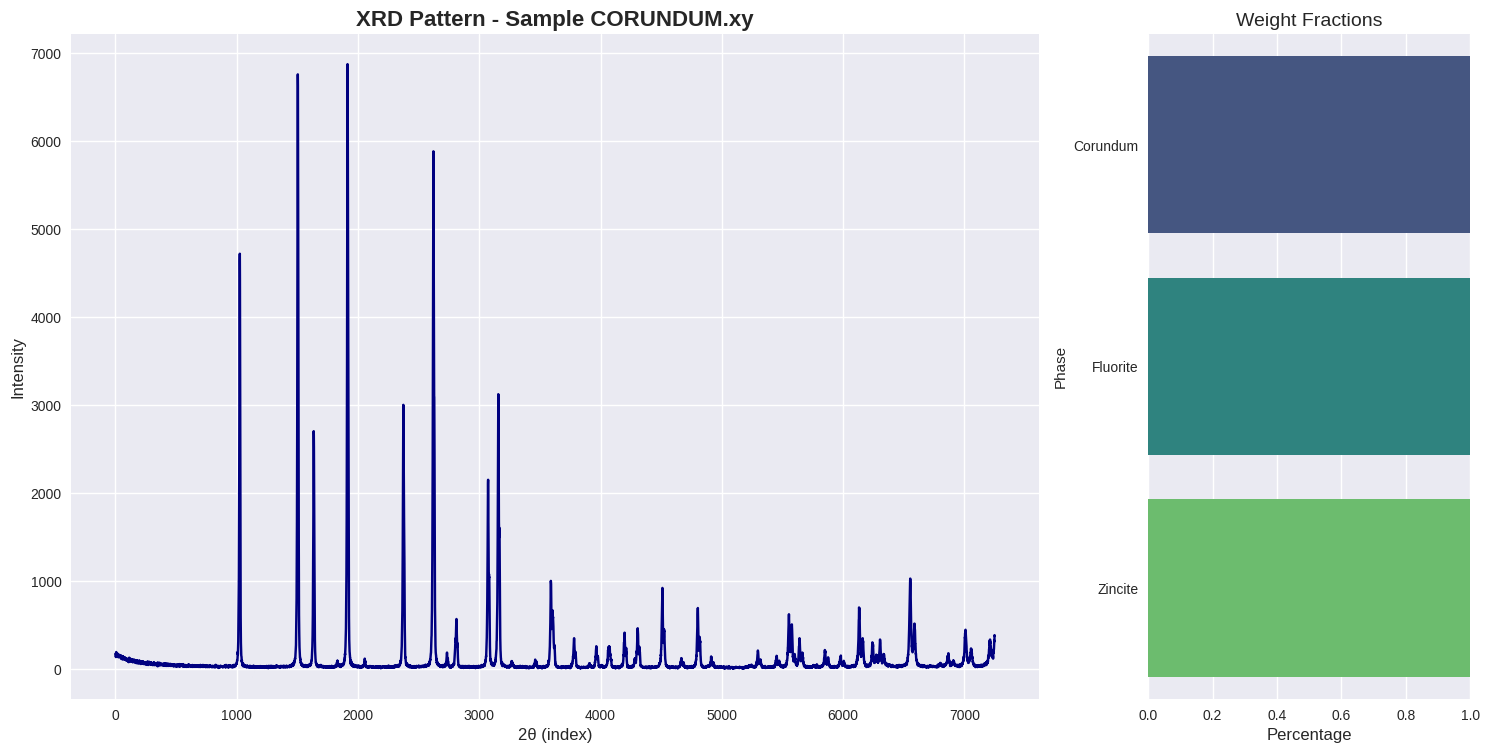

KeyError: 1

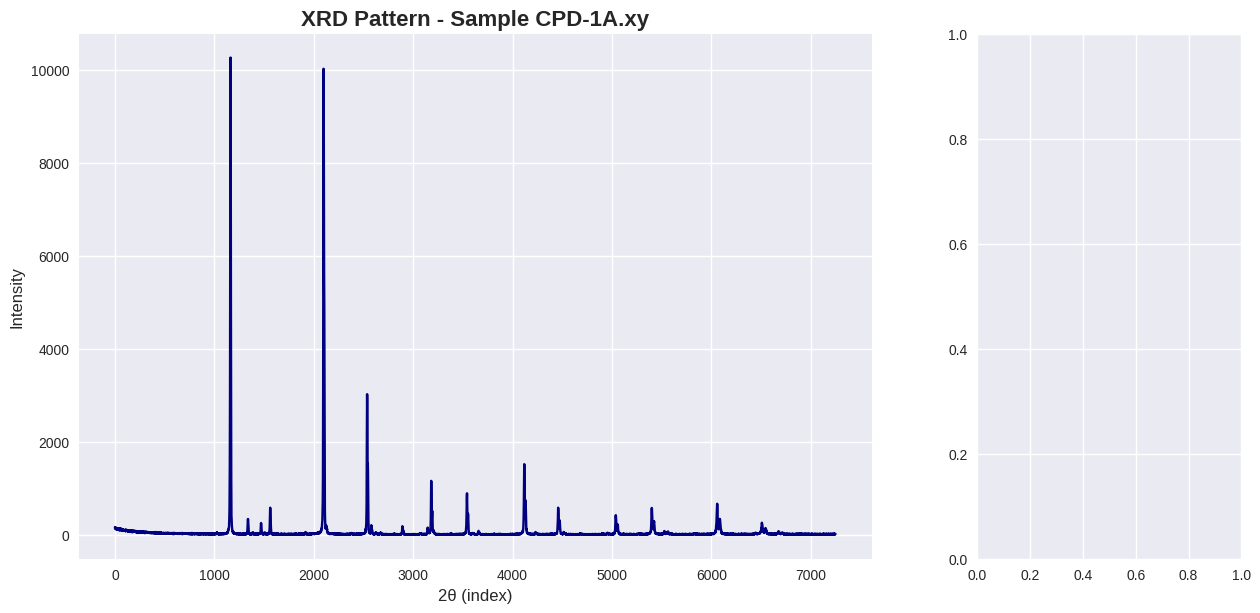

In [ ]:
# Plot all 11 XRD patterns with phase information
for i in range(11):
    sample_intensity = intensities[i][0]  # [0] to remove the channel dimension
    sample_weight_fractions = pd.DataFrame([predictions[i]], columns=weight_fractions.columns)
    
    plot_xrd_pattern(sample_intensity, i, sample_weight_fractions, None, 
                     f"XRD Pattern - Sample {xy_files[i]}")


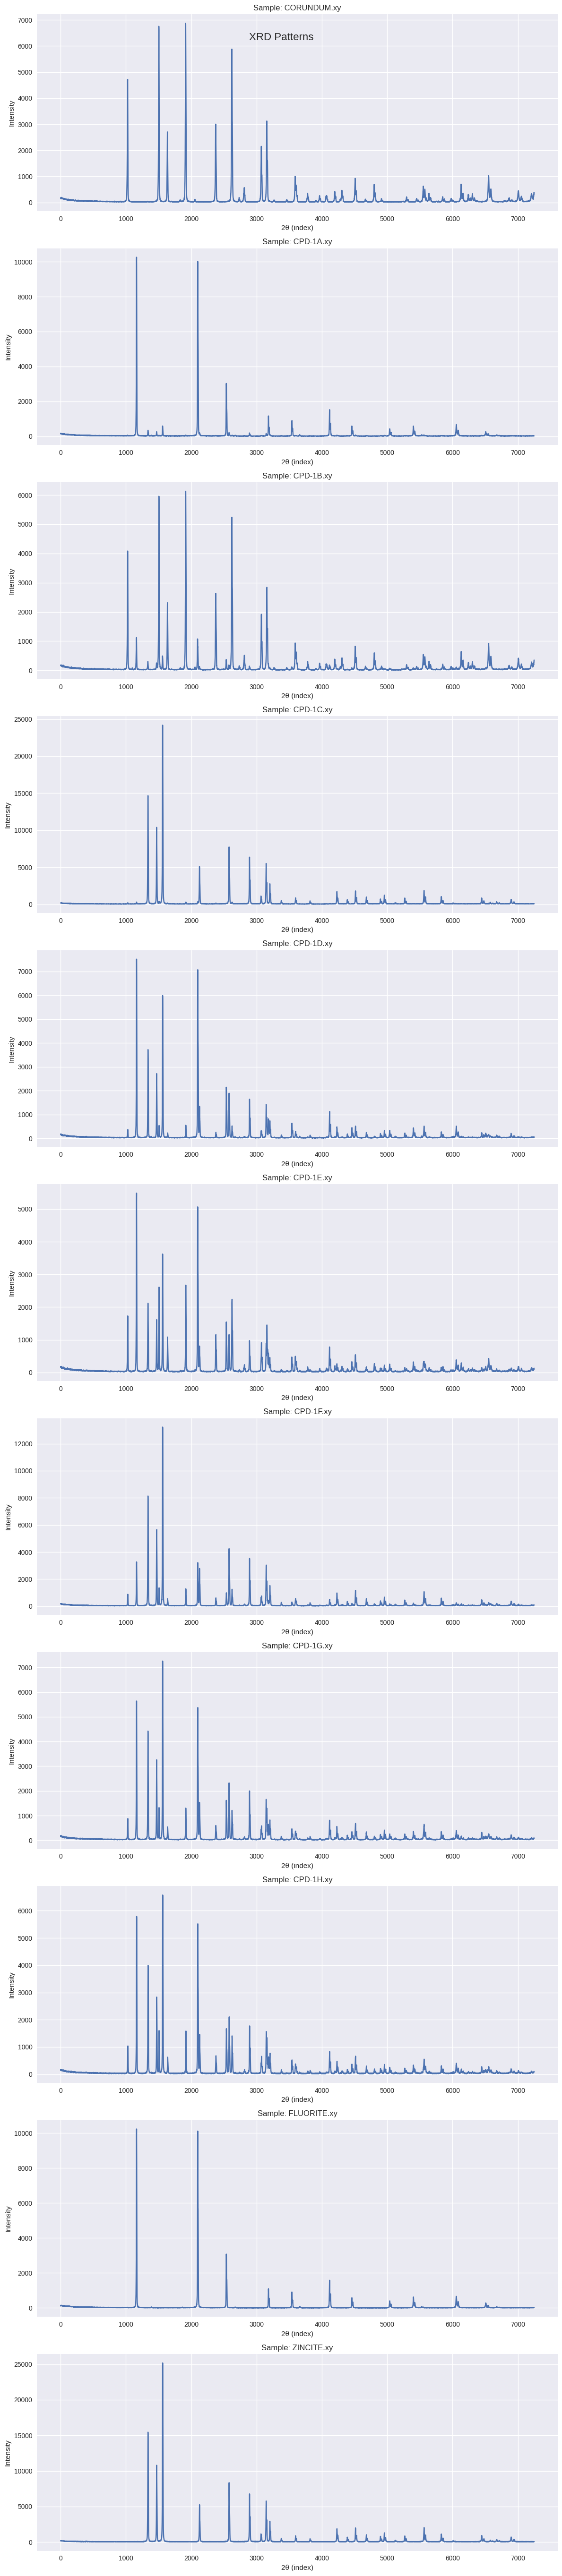

In [ ]:
# Function to plot XRD patterns
def plot_xrd_patterns(intensities, file_names, num_plots=11):
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 5*num_plots))
    fig.suptitle('XRD Patterns', fontsize=16)
    
    for i in range(min(num_plots, len(intensities))):
        ax = axes[i] if num_plots > 1 else axes
        ax.plot(intensities[i][0])  # [0] because we added a channel dimension earlier
        ax.set_title(f'Sample: {file_names[i]}')
        ax.set_xlabel('2θ (index)')
        ax.set_ylabel('Intensity')
    
    plt.tight_layout()
    plt.show()

# Plot the first 3 XRD patterns (or all if less than 3)
plot_xrd_patterns(intensities, xy_files)

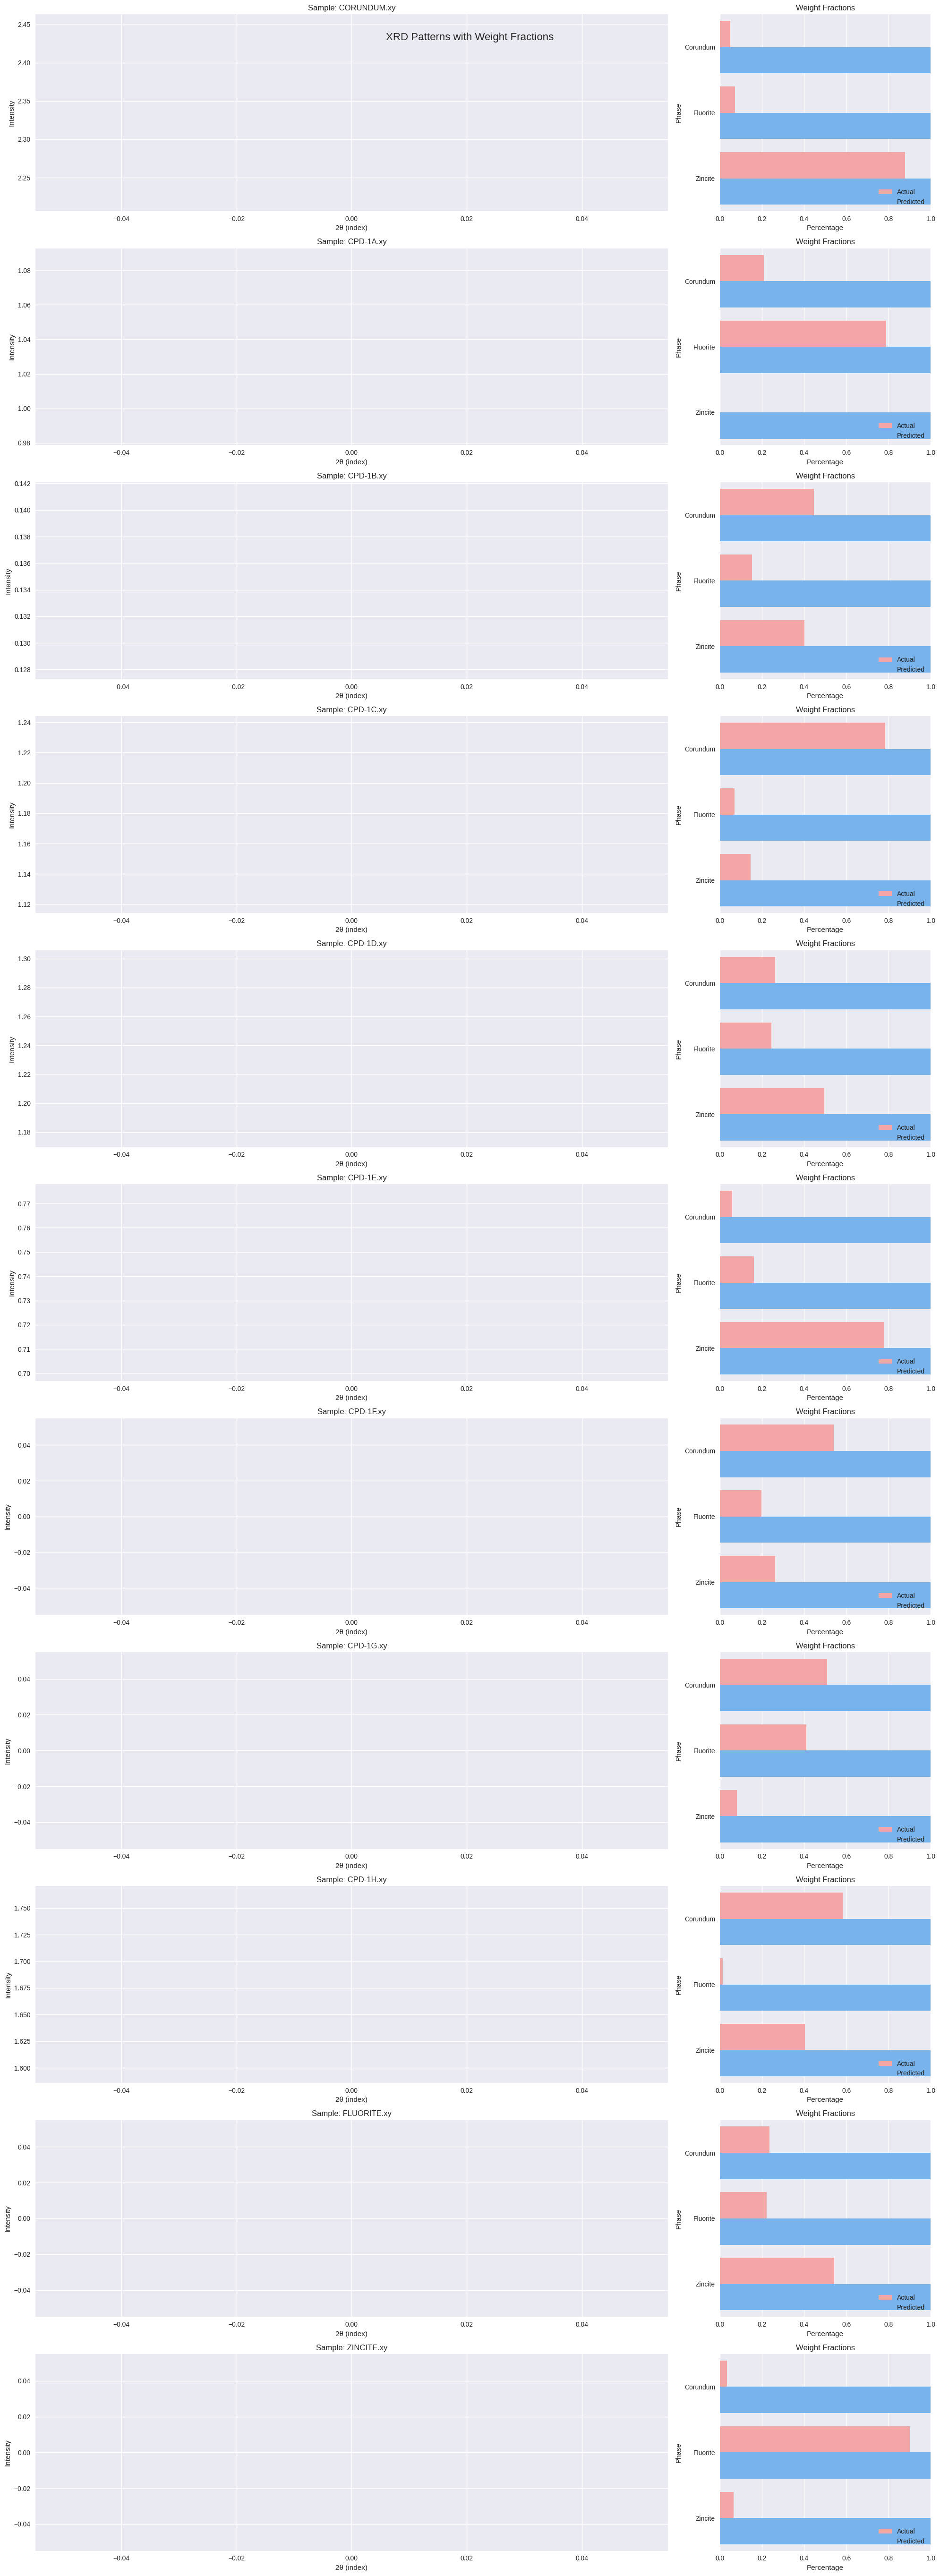

In [69]:
def plot_xrd_patterns(intensities, file_names, predictions, weight_fractions, num_plots=11):
    fig, axes = plt.subplots(num_plots, 2, figsize=(20, 5*num_plots), gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle('XRD Patterns with Weight Fractions', fontsize=16)
    
    # Create a fixed color map for all phases
    all_phases = weight_fractions.columns.tolist()
    color_palette = dict(zip(all_phases, sns.color_palette("viridis", len(all_phases))))
    
    for i in range(min(num_plots, len(intensities))):
        # Plot XRD pattern (keeping this part unchanged)
        ax_main = axes[i, 0] if num_plots > 1 else axes[0]
        ax_main.plot(intensities[i][0])  # [0] because we added a channel dimension earlier
        ax_main.set_title(f'Sample: {file_names[i]}')
        ax_main.set_xlabel('2θ (index)')
        ax_main.set_ylabel('Intensity')
        
        # Plot weight fractions as a horizontal bar chart
        ax_weight = axes[i, 1] if num_plots > 1 else axes[1]
        
        # Create a DataFrame with all phases, comparing predicted and actual values
        weight_df = pd.DataFrame({
            'Phase': all_phases + all_phases,
            'Percentage': list(predictions[i]) + list(weight_fractions.iloc[i]),
            'Type': ['Predicted'] * len(all_phases) + ['Actual'] * len(all_phases)
        })
        
        # Sort by the global order of phases
        weight_df['Phase'] = pd.Categorical(weight_df['Phase'], categories=all_phases, ordered=True)
        weight_df = weight_df.sort_values(['Phase', 'Type'])
        
        # Plot the bar chart
        sns.barplot(data=weight_df, x='Percentage', y='Phase', hue='Type', ax=ax_weight, palette=['#ff9999', '#66b3ff'])
        ax_weight.set_title('Weight Fractions')
        ax_weight.set_xlabel('Percentage')
        ax_weight.set_xlim(0, 1)
        ax_weight.legend(title='', loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Plot all XRD patterns with phase information
plot_xrd_patterns(intensities, xy_files, predictions, weight_fractions)